<h1>Image Recolouring Project</h1>

Project developed by Alejandro Cano Caldero and Jesús Moncada Ramírez for the subject Neural Networks and Deep Learning, University of Padova, 2022-23.


In [ ]:
# Import necessary libraries for our project.
import numpy as np

import torch

import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from torchvision.transforms import transforms

from torch.utils.data import DataLoader, Dataset  

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as op

In [ ]:
# Define the execution device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Mount in Google Drive. 
# Only execute if running in Google Colab and the dataset is on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2>1. Creating our dataset</h2>

For the dataset we have used [ImageNette](https://github.com/fastai/imagenette), a reduced version of ImageNet, specifically the fill size images version.

<code>ImageDataset</code> is a default dataset class for images . To create an instance of this class you have to specify the route of the image folder (<code>image_path</code>) and a list of transforms (<code>transforms</code>). Basically it is an adapted version of <code>torchvision.datasets.ImageFolder</code>. Note that only returns one image when accessing to an element in <code>\_\_getitem\_\_</code>.

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, image_path, transform=None):
    super(ImageDataset, self).__init__()
    self.data = datasets.ImageFolder(image_path,  transform)

  def __getitem__(self, idx):
    x, y = self.data[idx]
    return x

  def __len__(self):
    return len(self.data)

<code>TwoImagesDataset</code> is a dataset class combining two images datasets. In this case it returns two images when accessing to an element.

In [ ]:
class TwoImagesDataset(Dataset):
  def __init__(self, dataset1, dataset2):
    super(TwoImagesDataset, self).__init__()
    self.dataset1 = dataset1
    self.dataset2 = dataset2

  def __getitem__(self, idx):
    return self.dataset1[idx], self.dataset2[idx]

  def __len__(self):
    if len(self.dataset1) == len(self.dataset2):
      return len(self.dataset1)
    else:
      print('ERROR, len of dataset1 is different from len of dataset2')
      return len(self.dataset1)

First we will create a dataset class with all the images resized to <code>256 x 256</code> (<code>colored_data</code>), after we will create a dataset class with all the images resized to <code>256 x 256</code> in grayscale (<code>grayscale_data</code>). By last we will create the dataset class containing both kind of images (<code>dataset</code>).

In [ ]:
# If locating the dataset in Google Drive
img_path = 'drive/MyDrive/imagenette2/train'

# Define normalization [0, 255] --> [-1, 1] (Owing to the use of the tanh activation function)

colored_transform = transforms.Compose(
    [transforms.ToTensor(), # to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalization [0, 255] --> [-1, 1] (to the tanh activation function)
     transforms.Resize((256, 256)) # resize to (256, 256)
     ] )

grayscale_transform = transforms.Compose(
    [transforms.ToTensor(), # to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalization [0, 255] --> [-1, 1] (to the tanh activation function)
     transforms.Resize((256, 256)), # resize to (256, 256)
     transforms.Grayscale(3) # to grayscale
     ])

colored_data = ImageDataset(img_path, colored_transform)
grayscale_data = ImageDataset(img_path, grayscale_transform)
dataset = TwoImagesDataset(colored_data, grayscale_data)

To check everything was ok let's print the colored and the grayscale version of the same image.

Plotting a color image in the dataset:


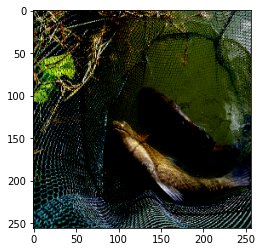

In [ ]:
def plot_image(img):
  plt.imshow(img.permute(1, 2, 0))

print('Plotting a color image in the dataset:')
plot_image(colored_data[0])

Plotting a grayscale image in the dataset:


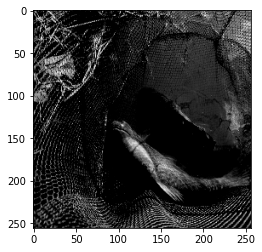

In [ ]:
print('Plotting a grayscale image in the dataset:')
plot_image(grayscale_data[0])

<h2>2. Discriminator</h2>

The discriminator used (called PatchGAN) takes as input an image of <code>(256x256)</code> and returns a tensor of <code>(30x30)</code>. The discriminator class is the following:

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1):
        super().__init__()
        
        self.layer1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=kernel_size, stride=2, padding=1)
        self.layer2 = nn.Conv2d(64, out_channels=128, kernel_size=kernel_size, stride=2, padding=1)
        self.layer2_bn = nn.BatchNorm2d(128)
        self.layer3 = nn.Conv2d(128, out_channels=256, kernel_size=kernel_size, stride=2, padding=1)
        self.layer3_bn = nn.BatchNorm2d(256)
        self.layer4 = nn.Conv2d(256, out_channels=512, kernel_size=kernel_size, padding=1) # stride = 1
        self.layer4_bn = nn.BatchNorm2d(512)
        self.layer5 = nn.Conv2d(512, out_channels=1, kernel_size=kernel_size, padding=1)
        
        # Weight initialization
        torch.nn.init.normal_(self.layer1.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer2.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer3.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer4.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer5.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer2_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer2_bn.bias.data, 0.0)
        torch.nn.init.normal_(self.layer3_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer3_bn.bias.data, 0.0)
        torch.nn.init.normal_(self.layer4_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer4_bn.bias.data, 0.0)

    def forward(self, x, verbose=False):
        d = F.leaky_relu(self.layer1(x), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer2_bn(self.layer2(d)), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer3_bn(self.layer3(d)), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer4_bn(self.layer4(d)), 0.2)
        if verbose:
          print(d.shape)
        d = self.layer5(d)
        if verbose:
          print(d.shape)
        
        # Each (1×1) of the 30×30 represents a 70×70 dimension 
        # in the input image (256×256), classifying a single patch of the original 
        # image as real or fake.
        return torch.sigmoid(d)

Let's create an object for the discriminator.

In [ ]:
test_discriminator = Discriminator(in_channels=6, kernel_size=4)
test_discriminator.to(device)

#loss_fn = nn.BCELoss(weight=torch.tensor(0.5))
#optimizer = op.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.5)

Discriminator(
  (layer1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (layer2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (layer2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (layer3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (layer4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

And let's execute the discriminator forward pass on a pair of images concatenated from dataset to check if it works.

In [ ]:
input_img, target_img = dataset[0]

input_img = input_img.unsqueeze(0)
target_img = target_img.unsqueeze(0)

disc_input = torch.cat((input_img, target_img), dim=1) # input of the discriminator
print("Dimension of image passed as argument: {0}".format(disc_input.shape))

res = test_discriminator.forward(disc_input) # forward pass discriminator

print("Dimension of discriminator output: {0}".format(res.shape))

Dimension of image passed as argument: torch.Size([1, 6, 256, 256])
Dimension of discriminator output: torch.Size([1, 1, 30, 30])


<h2>3. Generator</h2>

The generator used has an autoencoder style, with both encoder and decoder networks. The input and the output are images. It uses a UNET Generator, with skip connections.The generator class is the following:

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels, stride=1):
    super().__init__()

    # ----------------------------- ENCODER ----------------------------
    #            ENCODER MODEL: C64-C128-C256-C512-C512-C512-C512
    self.layer1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.layer2 = nn.Conv2d(64, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.layer2_bn = nn.BatchNorm2d(128)
    self.layer3 = nn.Conv2d(128, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.layer3_bn = nn.BatchNorm2d(256)
    self.layer4 = nn.Conv2d(256, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer4_bn = nn.BatchNorm2d(512)
    self.layer5 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer5_bn = nn.BatchNorm2d(512)
    self.layer6 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer6_bn = nn.BatchNorm2d(512)
    self.layer7 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer7_bn = nn.BatchNorm2d(512)
    # ----------------------------- /ENCODER ----------------------------


    # ----------------------------- BOTTLENECK ----------------------------
    self.bottleneck_layer = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    # ----------------------------- /BOTTLENECK ----------------------------


    # ----------------------------- DECODER ----------------------------
    #           DECODER MODEL: CD512-CD512-CD512-CD512-CD256-CD128-CD64
    self.layer8 = nn.ConvTranspose2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer8_bn = nn.BatchNorm2d(512)
    self.layer8_dpout = nn.Dropout()
    self.layer9 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer9_bn = nn.BatchNorm2d(512)
    self.layer9_dpout = nn.Dropout()
    self.layer10 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer10_bn = nn.BatchNorm2d(512)
    self.layer10_dpout = nn.Dropout()
    self.layer11 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer11_bn = nn.BatchNorm2d(512)
    self.layer12 = nn.ConvTranspose2d(1024, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.layer12_bn = nn.BatchNorm2d(256)
    self.layer13 = nn.ConvTranspose2d(512, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.layer13_bn = nn.BatchNorm2d(128)
    self.layer14 = nn.ConvTranspose2d(256, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.layer14_bn = nn.BatchNorm2d(64)
    # ----------------------------- /DECODER ----------------------------

    # ----------------------------- OUTPUT ----------------------------
    self.layer15 = nn.ConvTranspose2d(128, out_channels=3, kernel_size=4, stride=2, padding=1)

    # Weight initialization
    torch.nn.init.normal_(self.layer1.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer2.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer3.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer4.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer5.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer6.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer7.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.bottleneck_layer.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer8.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer9.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer10.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer11.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer12.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer13.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer14.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer15.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer2_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer2_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer3_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer3_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer4_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer4_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer5_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer5_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer6_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer6_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer7_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer7_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer8_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer8_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer9_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer9_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer10_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer10_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer11_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer11_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer12_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer12_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer13_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer13_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer14_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer14_bn.bias.data, 0.0)

  def forward(self, x):

    # ----------------------------- ENCODER ----------------------------
    print("-------------- DECODER --------------")
    e1 = F.leaky_relu(self.layer1(x), 0.2)
    print(e1.shape)
    e2 = F.leaky_relu(self.layer2_bn(self.layer2(e1)), 0.2)
    print(e2.shape)
    e3 = F.leaky_relu(self.layer3_bn(self.layer3(e2)), 0.2)
    print(e3.shape)
    e4 = F.leaky_relu(self.layer4_bn(self.layer4(e3)), 0.2)
    print(e4.shape)
    e5 = F.leaky_relu(self.layer5_bn(self.layer5(e4)), 0.2)
    print(e5.shape)
    e6 = F.leaky_relu(self.layer6_bn(self.layer6(e5)), 0.2)
    print(e6.shape)
    e7 = F.leaky_relu(self.layer7_bn(self.layer7(e6)), 0.2) 
    print(e7.shape)
    # ----------------------------- /ENCODER ----------------------------


    # ----------------------------- BOTTLENECK ----------------------------
    b = F.relu(self.bottleneck_layer(e7))
    print(b.shape)


    # ----------------------------- DECODER ----------------------------
    print("-------------- DECODER --------------")
    d1 = F.relu(torch.cat((self.layer8_dpout(self.layer8_bn(self.layer8(b))), e7), 1))
    print(d1.shape)
    d2 = F.relu(torch.cat((self.layer9_dpout(self.layer9_bn(self.layer9(d1))), e6), 1))
    print(d2.shape)
    d3 = F.relu(torch.cat((self.layer10_dpout(self.layer10_bn(self.layer10(d2))), e5), 1))
    print(d3.shape)
    d4 = F.relu(torch.cat(((self.layer11_bn(self.layer11(d3))), e4), 1))
    print(d4.shape)
    d5 = F.relu(torch.cat(((self.layer12_bn(self.layer12(d4))), e3), 1))
    print(d5.shape)
    d6 = F.relu(torch.cat(((self.layer13_bn(self.layer13(d5))), e2), 1))
    print(d6.shape)
    d7 = F.relu(torch.cat(((self.layer14_bn(self.layer14(d6))), e1), 1))
    print(d7.shape)

    # ----------------------------- OUTPUT ----------------------------
    o = torch.cat([torch.tanh(self.layer15(d7)), x], 1)

    return o

In [ ]:
generator = Generator(3)

In [ ]:
input_img, tg_img = dataset[0]
var = generator.forward(input_img.unsqueeze(0))
print("Output shape: ", var.shape)

-------------- DECODER --------------
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 2, 2])
torch.Size([1, 512, 1, 1])
-------------- DECODER --------------
torch.Size([1, 1024, 2, 2])
torch.Size([1, 1024, 4, 4])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 512, 32, 32])
torch.Size([1, 256, 64, 64])
torch.Size([1, 128, 128, 128])
Output shape:  torch.Size([1, 6, 256, 256])


<h2>4. Loss function</h2>

For the loss function, we are going to use the **Binary Cross-Entropy** loss

In [ ]:
adversarial_loss = nn.BCELoss(weight=torch.tensor(0.5))
l1_loss = nn.L1Loss()

Four parameters are fed to the generator_loss function:



1. **generated_image:** Images produced by the generator
2. **target_image:** Ground-truth pair image for the input fed to the generator.
3. **G**: Output predictions from the discriminator, when fed with generator-produced images.
4. **real_target:** Ground-truth labels (1), as you would like the generator to produce real images by fooling the discriminator. The labels therefore would be one.

In [ ]:
def generator_loss(generator_image, target_image, discriminator_predictions, real_target):
  gen_loss = adversarial_loss(discriminator_predictions, real_target)
  l1_l = l1_loss(generator_image, target_image)
  result = gen_loss + (100 * l1_l)

  return result

The discriminator loss has:

1. The real (original images) output predictions ground-truth label as 1
2. Fake (generated images) output predictions ground-truth label as 0.

In [ ]:
def discriminator_loss(output, label):
  return adversarial_loss(output, label)